In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

#### DATA FRAME in pandas #####
df = pd.DataFrame(data.data,columns=data.feature_names)
df2 = pd.DataFrame(data.target,columns=['target'])
final_dataset = pd.concat([df,df2],axis=1)
final_dataset.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [4]:
final_dataset.shape

(569, 31)

In [5]:
final_dataset['target'].value_counts()

1    357
0    212
Name: target, dtype: int64

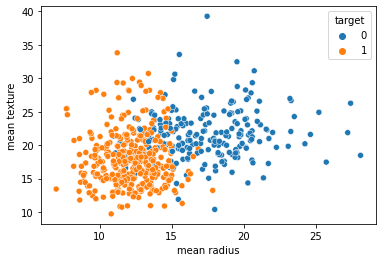

In [6]:
sns.scatterplot(data=final_dataset, x="mean radius", y="mean texture",hue='target')

In [12]:

!pip install torch

In [177]:
import torch
print(torch.cuda.is_available())
device = 'cuda' if torch.cuda.is_available() else 'cpu'

True


In [236]:

X = final_dataset.drop(['target'],axis=1)
y = final_dataset['target']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
from sklearn.preprocessing import StandardScaler
sm = StandardScaler()
X_train_scaled = sm.fit_transform(X_train)
X_test_scaled = sm.transform(X_test)

In [237]:
X_train=torch.FloatTensor(X_train_scaled).cuda()
X_test=torch.FloatTensor(X_test_scaled).cuda()
y_train= torch.LongTensor(y_train.values).cuda()
y_test=torch.LongTensor(y_test.values).cuda()

In [272]:
import torch
from torch import nn
import torchvision

class ANN_cancer(nn.Module):
  def __init__(self,input=30,hidden1=60,hidden2=40,output=2):
    super(ANN_cancer,self).__init__()
    self.FC1 = nn.Linear(input,hidden1)
    self.relu1 = nn.ReLU()
    self.FC2 = nn.Linear(hidden1,hidden2)
    self.relu2 = nn.ReLU()
    self.FC3 = nn.Linear(hidden2,output)
  def forward(self,x):
    x = self.FC1(x)
    x = self.relu1(x)
    x = self.FC2(x)
    x = self.relu2(x)
    x = self.FC3(x)
    #y_pred  = torch.sigmoid(x)
    return x 

In [281]:
model1 = ANN_cancer()
loss_fn = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr = 0.01)

In [282]:
model1  = model1.cuda()

In [283]:
print(model1.parameters)

<bound method Module.parameters of ANN_cancer(
  (FC1): Linear(in_features=30, out_features=60, bias=True)
  (relu1): ReLU()
  (FC2): Linear(in_features=60, out_features=40, bias=True)
  (relu2): ReLU()
  (FC3): Linear(in_features=40, out_features=2, bias=True)
)>


In [284]:
epochs = 600
final_losses=[]
for i in range(epochs):
  y_pred1 = model1.forward(X_train)
  
  optimizer1.zero_grad()
  #l1 = loss_fn(y_pred1,y_train.reshape(-1,1))
  l1 = loss_fn(y_pred1,y_train)
  if i%10 == 0:
    print("Epoch number: {} and the loss : {}".format(i,l1))
  l1.backward()
  final_losses.append(l1)
  optimizer1.step()
  

  


Epoch number: 0 and the loss : 0.731686532497406
Epoch number: 10 and the loss : 0.07419878244400024
Epoch number: 20 and the loss : 0.040923576802015305
Epoch number: 30 and the loss : 0.018382443115115166
Epoch number: 40 and the loss : 0.006883692927658558
Epoch number: 50 and the loss : 0.002569825854152441
Epoch number: 60 and the loss : 0.0010524585377424955
Epoch number: 70 and the loss : 0.0005515427328646183
Epoch number: 80 and the loss : 0.0003368195903021842
Epoch number: 90 and the loss : 0.0002376161137362942
Epoch number: 100 and the loss : 0.00018117111176252365
Epoch number: 110 and the loss : 0.00014731657574884593
Epoch number: 120 and the loss : 0.00012343910930212587
Epoch number: 130 and the loss : 0.00010591509635560215
Epoch number: 140 and the loss : 9.223502274835482e-05
Epoch number: 150 and the loss : 8.122962026391178e-05
Epoch number: 160 and the loss : 7.220272527774796e-05
Epoch number: 170 and the loss : 6.470896914834157e-05
Epoch number: 180 and the l

Text(0.5, 0, 'Epoch')

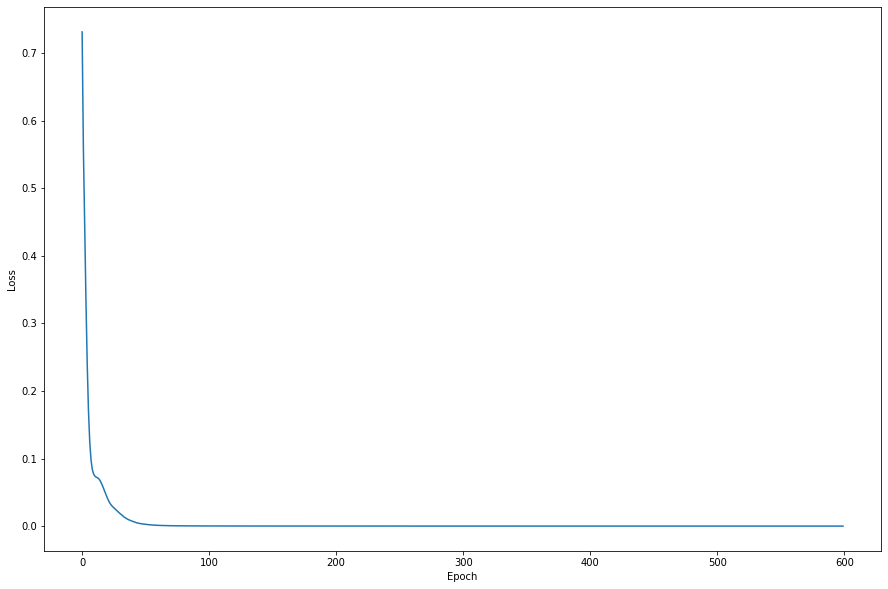

In [285]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.plot(range(epochs),final_losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [286]:
predictions=[]
with torch.no_grad():
    for i,data in enumerate(X_test):
        y_pred12=model1(data)
        predictions.append(y_pred12.argmax().item())
        

In [287]:
y_test1 = y_test.cpu().numpy()
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test1,predictions)
cm

array([[ 61,   2],
       [  2, 106]])

In [288]:
from sklearn.metrics import accuracy_score
score=accuracy_score(y_test1,predictions)
score

0.9766081871345029

In [290]:
##################### New ##################

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [291]:
correlation(final_dataset,0.9)

{'area error',
 'mean area',
 'mean concave points',
 'mean perimeter',
 'perimeter error',
 'worst area',
 'worst concave points',
 'worst perimeter',
 'worst radius',
 'worst texture'}

In [292]:

##### Dropping highly corelated columns #####################

final_dataset =  final_dataset.drop(['area error',
 'mean area',
 'mean concave points',
 'mean perimeter',
 'perimeter error',
 'worst area',
 'worst concave points',
 'worst perimeter',
 'worst radius',
 'worst texture'],axis=1)

In [293]:
final_dataset.shape

(569, 21)

In [295]:
X = final_dataset.drop(['target'],axis=1)
y = final_dataset['target']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

from sklearn.preprocessing import StandardScaler
sm = StandardScaler()
X_train_scaled = sm.fit_transform(X_train)
X_test_scaled = sm.transform(X_test)

X_train=torch.FloatTensor(X_train_scaled).cuda()
X_test=torch.FloatTensor(X_test_scaled).cuda()
y_train= torch.LongTensor(y_train.values).cuda()
y_test=torch.LongTensor(y_test.values).cuda()


In [391]:
import torch
from torch import nn
import torchvision

class ANN_cancer_corr(nn.Module):
  def __init__(self,input=20,hidden1=40,hidden2=20,output=2):
    super(ANN_cancer_corr,self).__init__()
    self.FC1 = nn.Linear(input,hidden1)
    self.relu1 = nn.ReLU()
    self.FC2 = nn.Linear(hidden1,hidden2)
    self.relu2 = nn.ReLU()
    self.FC3 = nn.Linear(hidden2,output)
  def forward(self,x):
    x = self.FC1(x)
    x = self.relu1(x)
    x = self.FC2(x)
    x = self.relu2(x)
    x = self.FC3(x)
    #y_pred  = torch.sigmoid(x)
    return x 

model2 = ANN_cancer_corr()
loss_fn = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model2.parameters(), lr = 0.015)


model2  = model2.cuda()
epochs = 200
final_losses=[]
for i in range(epochs):
  y_pred1 = model2.forward(X_train)
  
  optimizer1.zero_grad()
  #l1 = loss_fn(y_pred1,y_train.reshape(-1,1))
  l1 = loss_fn(y_pred1,y_train)
  if i%10 == 0:
    print("Epoch number: {} and the loss : {}".format(i,l1))
  l1.backward()
  final_losses.append(l1)
  optimizer1.step()

Epoch number: 0 and the loss : 0.6371100544929504
Epoch number: 10 and the loss : 0.09274987131357193
Epoch number: 20 and the loss : 0.03091474063694477
Epoch number: 30 and the loss : 0.008846224285662174
Epoch number: 40 and the loss : 0.0024916513357311487
Epoch number: 50 and the loss : 0.0009975164430215955
Epoch number: 60 and the loss : 0.0004798441950697452
Epoch number: 70 and the loss : 0.00029680586885660887
Epoch number: 80 and the loss : 0.00020978240354452282
Epoch number: 90 and the loss : 0.00016081426292657852
Epoch number: 100 and the loss : 0.00012993282871320844
Epoch number: 110 and the loss : 0.00010764157195808366
Epoch number: 120 and the loss : 9.120059257838875e-05
Epoch number: 130 and the loss : 7.860087498556823e-05
Epoch number: 140 and the loss : 6.74747207085602e-05
Epoch number: 150 and the loss : 5.732489444199018e-05
Epoch number: 160 and the loss : 4.827912198379636e-05
Epoch number: 170 and the loss : 4.083819658262655e-05
Epoch number: 180 and the

Text(0.5, 0, 'Epoch')

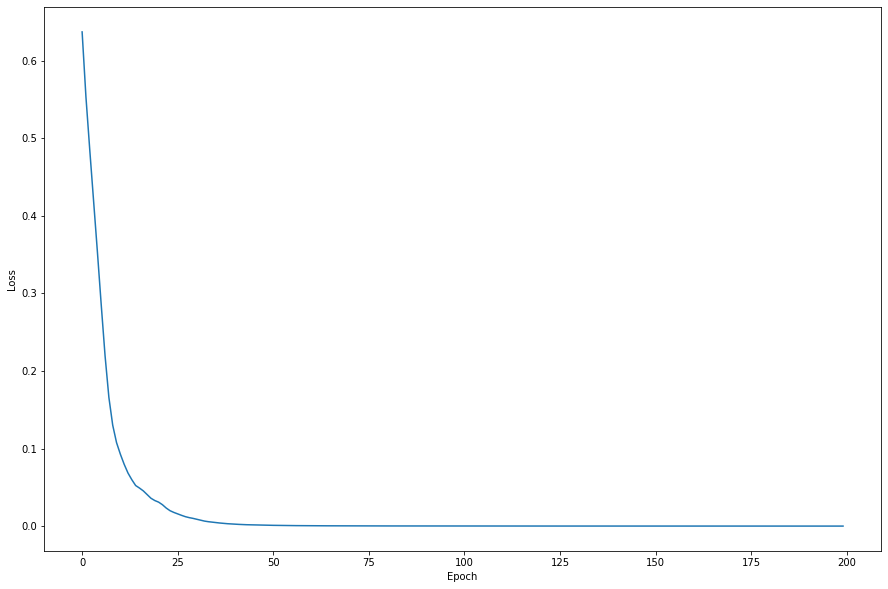

In [392]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.plot(range(epochs),final_losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [393]:
predictions=[]
with torch.no_grad():
    for i,data in enumerate(X_test):
        y_pred12=model2(data)
        predictions.append(y_pred12.argmax().item())

In [394]:
y_test1 = y_test.cpu().numpy()
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test1,predictions)
cm

array([[ 57,   4],
       [  0, 110]])

In [395]:
from sklearn.metrics import accuracy_score
score=accuracy_score(y_test1,predictions)
score

0.9766081871345029